In [ ]:
import logging
from copy import copy
from enum import Enum

import numpy as np
np.set_printoptions(suppress=True)
np.set_printoptions(formatter={'float': lambda x: "{0:0.3f}".format(x)})

from IPython.display import SVG,display
import pydot

from IPython.display import clear_output
from pydrake.all import (AbstractValue, AddMultibodyPlantSceneGraph, AngleAxis,
                         Concatenate, DiagramBuilder, InputPortIndex,
                         LeafSystem, MeshcatVisualizer, ContactVisualizerParams, ContactVisualizer, MeshcatVisualizerParams, Parser,
                         PiecewisePolynomial, PiecewisePose, PointCloud, RandomGenerator, RigidTransform,
                         RollPitchYaw, Simulator, StartMeshcat,
                         UniformlyRandomRotationMatrix,
                         BsplineTrajectory, Sphere, Rgba,
                         KinematicTrajectoryOptimization, Solve, MinimumDistanceConstraint,
                         PositionConstraint, ModelInstanceIndex,
                         SpatialVelocity, LinearConstraint, BoundingBoxConstraint, LogVectorOutput,
                         IpoptSolver,SnoptSolver)

from manipulation import FindResource, running_as_notebook
from manipulation.meshcat_utils import AddMeshcatTriad
from manipulation.scenarios import (AddPackagePaths,
                                    MakeManipulationStation, AddIiwa, AddShape, AddWsg, AddMultibodyTriad)

import matplotlib.pyplot as plt
from matplotlib.widgets import TextBox
from io import StringIO
import sys

from utils import *
from diff_ik_adjuster import *

In [ ]:
# Start the visualizer.
helper_meshcat = StartMeshcat()
meshcat = StartMeshcat()

INFO:drake:Meshcat listening for connections at https://68a898be-bd4e-4046-916a-6293aadf6c5d.deepnoteproject.com/7001/


INFO:drake:Meshcat listening for connections at https://68a898be-bd4e-4046-916a-6293aadf6c5d.deepnoteproject.com/7002/


# Configuration

In [ ]:
internal_model = make_internal_model()
# Manipulation Station Parameters
time_step=0.0001

# use_direct determines whether to feed the desired q, v, a into InverseDynamicsController
# or to use the default position based iiwa controller
use_direct = True

display_plot = True
add_text_to_pdf = False
should_print_contact_results = False

squash_ball_radius = 0.02

p_GB_G = [0, 0.11, 0]

q_Throw = np.array([-0.54, 0.58, 0, -1.79, 0, -0.79, 0])
p_WThrow = [0.57, -0.34, 0.39]
R_WThrow = RollPitchYaw([-np.pi, 0.00, 1.03])

q_Catch = np.array([-0.74, 0.58, 0, -1.79, 0, -0.79, 0])
p_WCatch = [0.49, -0.45, 0.39]
R_WCatch = RollPitchYaw([-np.pi, 0.00, 0.83])

X_WThrow = RigidTransform(R_WThrow, p_WThrow)
X_WCatch = RigidTransform(R_WCatch, p_WCatch)

X_WThrowB_W, X_WCatchB_W = get_ball_poses_from_gripper_poses(X_WThrow, X_WCatch, p_GB_G)

max_height = 1.5 # Max height ball will reach in meters
V_ThrowB, V_CatchB, t_duration = calculate_ball_vels(X_WThrowB_W.translation(), X_WCatchB_W.translation(), max_height)
t_duration = round(t_duration,3)

sim_duration = 3.5 * t_duration

v_Throw = convert_spatial_vel_ball_to_joint_vel_arm(q_Throw, V_ThrowB, p_GB_G)
v_Catch = convert_spatial_vel_ball_to_joint_vel_arm(q_Catch, V_CatchB, p_GB_G)

# WSG gripper
wsg_buff_open = 0.001
wsg_buff_close = 0.07
should_release_ball = True
if should_release_ball:
    opened = np.array([0.090])
else:
    opened = np.array([0.02])
closed = np.array([0.01])

# Kin Traj Opt Parameters
num_control_points = 15

The order of operations:
1. We start with comfortable joint angles for the iiwa q_throw and q_catch.
1. We use forward kinematics to get spatial positions p_WThrow and p_WCatch
1. we translate those by the offset between the ball and the gripper p_GB_G, to get the spatial positions the ball will be in at the point of being thrown (release) and caught X_WThrowB_W, X_WCatchB_W
1. we calculate using simple physics the spatial velocity of the ball at the point of being thrown and caught V_WThrowB_W, V_WCatchB_W, as well as the joint angle for the last iiwa link (rotation of the gripper such that it will parallel to the velocity of the ball), given a particular max height h that it reaches.
1. we use the Jacobian to transform the spatial velocities of the ball into joint velocities of the iiwa v_Throw and v_Catch, taking into account the offset between the gripper and the ball.
1. We feed the joint positions and velocities into kin traj opt so they can be used as constraints to optimize the trajectory.


In [ ]:
# Joint position and velocity constraints
def make_kin_traj_opt_trajectory(q0, q1, v0, v1, t_duration):
    context = internal_model.CreateDefaultContext()
    plant = internal_model.GetSubsystemByName("plant")
    plant_context = plant.GetMyContextFromRoot(context)

    num_positions = 7
    trajopt = KinematicTrajectoryOptimization(num_positions, num_control_points)
    prog = trajopt.get_mutable_prog()

    q_guess = np.tile(q0.reshape((num_positions,1)), (1, trajopt.num_control_points()))
    q_guess[0,:] = np.linspace(q0[0], q1[0], trajopt.num_control_points())
    path_guess = BsplineTrajectory(trajopt.basis(), q_guess)
    trajopt.SetInitialGuess(path_guess)
    
    trajopt.AddPathLengthCost(1)

    trajopt.AddPositionBounds(plant.GetPositionLowerLimits()[:num_positions],
                              plant.GetPositionUpperLimits()[:num_positions])
    trajopt.AddVelocityBounds(plant.GetVelocityLowerLimits()[:num_positions],
                              plant.GetVelocityUpperLimits()[:num_positions])
    # trajopt.AddVelocityBounds([-10] * 7, [10] * 7) # Super high velocity limits

    trajopt.AddDurationConstraint(2 * t_duration, 2 * t_duration)

    eps = 0.001
    lb0, ub0 = offset_vec_by_eps(q0, eps)
    lb1, ub1 = offset_vec_by_eps(q1, eps)

    # constrain positions in joint angles
    trajopt.AddPathPositionConstraint(lb0, ub0, 0)
    trajopt.AddPathPositionConstraint(lb1, ub1, 0.5)
    trajopt.AddPathPositionConstraint(lb0, ub0, 1)

    # prog.AddQuadraticErrorCost(np.eye(7), q0,
    #                            trajopt.control_points()[:, 0])
    
    # prog.AddQuadraticErrorCost(np.eye(7), q1,
    #                            trajopt.control_points()[:, np.round(num_control_points/2).astype(int)])

    # prog.AddQuadraticErrorCost(np.eye(7), q0,
    #                            trajopt.control_points()[:, -1])
    
    q_q_dot1 = np.concatenate((q1.reshape(num_positions,1), v1), axis = 0)
    q_q_dot0 = np.concatenate((q0.reshape(num_positions,1), v0), axis = 0)
    q_q_dot1.reshape(2 * num_positions,1)
    q_q_dot0.reshape(2 * num_positions,1)

    eps = 0.001
    lb0, ub0 = offset_vec_by_eps(q_q_dot0, eps)
    lb1, ub1 = offset_vec_by_eps(q_q_dot1, eps)

    q_dot_bbox_constraint0 = BoundingBoxConstraint(lb0, ub0)
    q_dot_bbox_constraint1 = BoundingBoxConstraint(lb1, ub1)

    trajopt.AddVelocityConstraintAtNormalizedTime(q_dot_bbox_constraint0, 0)
    trajopt.AddVelocityConstraintAtNormalizedTime(q_dot_bbox_constraint1, 0.5)
    trajopt.AddVelocityConstraintAtNormalizedTime(q_dot_bbox_constraint0, 1)

    solver = SnoptSolver()
    result = solver.Solve(prog)
    if not result.is_success():
        print("Trajectory optimization failed, even without collisions!")
        print(result.get_solver_id().name())
    else:
        print("Trajectory optimization succeeded!")
    
    pos_traj = trajopt.ReconstructTrajectory(result)
    vel_traj = pos_traj.MakeDerivative()
    acc_traj = vel_traj.MakeDerivative()

    return pos_traj, vel_traj, acc_traj

In [ ]:
class PlannerState(Enum):
    WAIT_FOR_OBJECTS_TO_SETTLE = 1
    PERPETUAL_MOTION = 2
    THINKING = 3

class Planner(LeafSystem):
    def __init__(self, plant, ball_body_index):
        LeafSystem.__init__(self)
        self._ball_body_index = ball_body_index
        self._diff_ik_adjuster = DiffIKAdjuster(helper_meshcat)
        self._body_poses_index = self.DeclareAbstractInputPort("body_poses",
            AbstractValue.Make([RigidTransform()])).get_index()
        self._body_spatial_velocities_index = self.DeclareAbstractInputPort("body_spatial_velocities",
                AbstractValue.Make([SpatialVelocity()])).get_index()
        self._throw_pose_index = self.DeclareAbstractInputPort(
            "throw_pose", AbstractValue.Make(
                (np.inf, RigidTransform()))).get_index()
        self._catch_pose_index = self.DeclareAbstractInputPort(
            "catch_pose", AbstractValue.Make(
                (np.inf, RigidTransform()))).get_index()
        self._wsg_state_index = self.DeclareVectorInputPort("wsg_state",
                                                            2).get_index()

        self._mode_index = self.DeclareAbstractState(
            AbstractValue.Make(PlannerState.PERPETUAL_MOTION))
        self._traj_wsg_index = self.DeclareAbstractState(
            AbstractValue.Make(PiecewisePolynomial()))
        self._times_index = self.DeclareAbstractState(AbstractValue.Make(
            {"initial": 0.0}))
        
        self._traj_start_time_index = self.DeclareAbstractState(
            AbstractValue.Make(0.0)
        )

        self.DeclareVectorOutputPort("wsg_position", 1, self.CalcWsgPosition)
        self.DeclareVectorOutputPort("traj_start_time", 1, self.GetTrajStartTime)
        # For Perpetual Motion mode.
        num_positions = 7
        self._iiwa_position_index = self.DeclareVectorInputPort(
            "iiwa_position", num_positions).get_index()
                
        self.DeclareVectorOutputPort("iiwa_state_desired", 2 * num_positions,
                                     self.CalcIiwaDesiredState)
        self.DeclareVectorOutputPort("iiwa_acceleration_desired", num_positions,
                                     self.CalcIiwaDesiredAcceleration)
        self.DeclareVectorOutputPort("iiwa_position_command", num_positions,
                                     self.CalcIiwaPosition)

        self._traj_arm_q_index = self.DeclareAbstractState(
            AbstractValue.Make(BsplineTrajectory())
        )
        self._traj_arm_v_index = self.DeclareAbstractState(
            AbstractValue.Make(BsplineTrajectory())
        )
        self._traj_arm_a_index = self.DeclareAbstractState(
            AbstractValue.Make(BsplineTrajectory())
        )

        self.DeclareInitializationUnrestrictedUpdateEvent(self.InitializeTrajectory)
        self.DeclarePeriodicUnrestrictedUpdateEvent(2 * t_duration, t_duration, self.TrajUpdate) # update after throw
    
    def InitializeTrajectory(self, context, state):
        # iiwa trajectory
        q_traj, v_traj, a_traj= make_kin_traj_opt_trajectory(
            q_Catch,
            q_Throw, 
            v_Catch,
            v_Throw, 
            t_duration)

        # Store them in states
        state.get_mutable_abstract_state(int(
            self._traj_start_time_index)).set_value(0.0)
        state.get_mutable_abstract_state(int(
            self._traj_arm_q_index)).set_value(q_traj)
        state.get_mutable_abstract_state(int(
            self._traj_arm_v_index)).set_value(v_traj)
        state.get_mutable_abstract_state(int(
            self._traj_arm_a_index)).set_value(a_traj)

        # WSG Gripper Trajectory
        throw_time = t_duration
        catch_time = t_duration*2
        
        times = [0, throw_time-wsg_buff_open, throw_time, catch_time-wsg_buff_close, catch_time]
        positions = np.hstack([[closed], [closed], [opened], [opened], [closed]])
        traj_wsg_command = PiecewisePolynomial.FirstOrderHold(times, positions)

        state.get_mutable_abstract_state(int(
            self._traj_wsg_index)).set_value(traj_wsg_command)
    
    def TrajUpdate(self, context, state):
        current_time = context.get_time()
        print(f'Update trajectory at {current_time}')
        
        p_WBall = self.get_input_port(self._body_poses_index).Eval(context)[self._ball_body_index].translation()
        V_WBall = self.get_input_port(self._body_spatial_velocities_index).Eval(context)[self._ball_body_index].translational()
        
        p_CatchB, V_CatchB = catch_pv_from_ball_pvt(p_WBall, V_WBall, t_duration) # calculated from p_WBall and V_WBall and t_duration
        q_Catch_predicted  = self._diff_ik_adjuster.get_joint_pos_for_spatial_pos(
                                        q_Catch, p_CatchB) # diff inverse kinematic towards p_CatchB using q_Catch_original        
        v_Catch_predicted = convert_spatial_vel_ball_to_joint_vel_arm(q_Catch_predicted, V_CatchB, p_GB_G)
        
        q_traj, v_traj, a_traj= make_kin_traj_opt_trajectory(
            q_Throw, 
            q_Catch_predicted, 
            v_Throw, 
            v_Catch_predicted, 
            t_duration)

        # Store them in states
        state.get_mutable_abstract_state(int(
            self._traj_start_time_index)).set_value(current_time)
        state.get_mutable_abstract_state(int(
            self._traj_arm_q_index)).set_value(q_traj)
        state.get_mutable_abstract_state(int(
            self._traj_arm_v_index)).set_value(v_traj)
        state.get_mutable_abstract_state(int(
            self._traj_arm_a_index)).set_value(a_traj)

        return

    def CalcWsgPosition(self, context, output):
        traj_wsg = context.get_abstract_state(int(
                self._traj_wsg_index)).get_value()
        traj_start_time = context.get_mutable_abstract_state(int(
                self._traj_start_time_index)).get_value()
        # Evaluate the trajectory at the current time, and write it to the
        # output port.
        output.SetFromVector(traj_wsg.value(context.get_time()%(2*t_duration)))

        traj_start_time = context.get_mutable_abstract_state(int(
                self._traj_start_time_index)).get_value()

    def CalcIiwaPosition(self, context, output):
        traj_q = context.get_mutable_abstract_state(int(
                self._traj_arm_q_index)).get_value()
        traj_start_time = context.get_mutable_abstract_state(int(
                self._traj_start_time_index)).get_value()
        output.SetFromVector(
            traj_q.value(
                context.get_time()-traj_start_time))

    def GetTrajStartTime(self, context, output):
        traj_start_time = context.get_abstract_state(int(self._traj_start_time_index)).get_value()
        output.SetFromVector([traj_start_time])

    def CalcIiwaDesiredState(self, context, output):
        traj_q = context.get_mutable_abstract_state(int(
                self._traj_arm_q_index)).get_value()
        traj_v = context.get_mutable_abstract_state(int(
                self._traj_arm_v_index)).get_value()
        traj_start_time = context.get_mutable_abstract_state(int(
                self._traj_start_time_index)).get_value()

        traj_v_value = traj_v.value(context.get_time()-traj_start_time)
        traj_q_value = traj_q.value(context.get_time()-traj_start_time)
        traj_state_value = np.concatenate((traj_q_value, traj_v_value), axis=0)
        
        output.SetFromVector(traj_state_value)
        print(context.get_time()-traj_start_time)
    
    def CalcIiwaDesiredAcceleration(self, context, output):
        traj_a = context.get_mutable_abstract_state(int(
                self._traj_arm_a_index)).get_value()
        traj_start_time = context.get_mutable_abstract_state(int(
                self._traj_start_time_index)).get_value()

        traj_a_value = traj_a.value(context.get_time()-traj_start_time)
        output.SetFromVector(traj_a_value)            



In [ ]:
class BallValidator(LeafSystem):
    def __init__(self, name, body_index):
        LeafSystem.__init__(self)
        self._body_index = body_index
        self._traj_start_time_index = self.DeclareVectorInputPort("traj_start_time",1).get_index()
        self._body_poses_index = self.DeclareAbstractInputPort("body_poses",
                                    AbstractValue.Make([RigidTransform()])).get_index()
        self._body_spatial_velocities_index = self.DeclareAbstractInputPort("body_spatial_velocities",
                                    AbstractValue.Make([SpatialVelocity()])).get_index()
        self.DeclareForcedPublishEvent(self.Publish)

        self.DeclarePeriodicUnrestrictedUpdateEvent(0.001, 0.0, self.Update)

        self.find_pos_match = False
    
    def Update(self, context, state):
        traj_start_time = self.get_input_port(self._traj_start_time_index).Eval(context)
        pose = self.get_input_port(self._body_poses_index).Eval(context)[self._body_index]
        velocity = self.get_input_port(self._body_spatial_velocities_index).Eval(context)[self._body_index]

        if (context.get_time() == traj_start_time + t_duration): # traj_start_time + original_t_duration
            print(f"\nWe are at throw time! ({context.get_time()})")
            print(f"actual ball position = {pose.translation()}")
            print(f"actual ball velocity: {velocity.translational()}")
            meshcat.SetObject("actual_throw", Sphere(squash_ball_radius), rgba=Rgba(.1, .1, .9, 1))
            meshcat.SetTransform("actual_throw", pose)
            self.find_pos_match = True

        if (context.get_time() == 2 * t_duration): # traj_start_time + 2 * t_duration
            print(f"\nWe are at catch time! ({context.get_time()})")
            print(f"actual ball position = {pose.translation()}")
            print(f"actual ball velocity: {velocity.translational()}")
            meshcat.SetObject("actual_catch", Sphere(squash_ball_radius), rgba=Rgba(.9, .1, .9, 1))
            meshcat.SetTransform("actual_catch", pose)
            self.find_pos_match = True

        if self.find_pos_match and vectors_within_eps(pose.translation(), X_WCatchB_W.translation()):
            print(f"\nBall pose matches catch pose at ({context.get_time()})")
            print(f"actual ball velocity: {velocity.translational()}")
            self.find_pos_match = False

        if self.find_pos_match and vectors_within_eps(pose.translation(), X_WThrowB_W.translation()):
            print(f"\nBall pose matches throw pose at ({context.get_time()})")
            print(f"actual ball velocity: {velocity.translational()}")
            self.find_pos_match = False

        vel_eps = 0.001
        if vectors_within_eps(velocity.translational(), V_CatchB, vel_eps):
            print(f"\nBall velocity matches catch velocity at ({context.get_time()})")
            print(f"actual ball velocity: {velocity.translational()}")
            print(f"actual ball position = {pose.translation()}")
        
        if vectors_within_eps(velocity.translational(), V_ThrowB, vel_eps):
            print(f"\nBall velocity matches throw velocity at ({context.get_time()})")
            print(f"actual ball velocity: {velocity.translational()}")
            print(f"actual ball position = {pose.translation()}")


0.5335999999999999
0.5335999999999999
0.5336499999999997
0.5336999999999996
0.5336999999999996
0.5336999999999996
0.5336999999999996
0.5337499999999995
0.5337999999999998
0.5337999999999998
0.5337999999999998
0.5337999999999998
0.5338499999999997
0.5338999999999996
0.5338999999999996
0.5338999999999996
0.5338999999999996
0.5339499999999995
0.5339999999999994
0.5339999999999994
0.5339999999999994
0.5339999999999998
0.5339999999999998
0.5339999999999998
0.5339999999999998
0.5339999999999998
0.5340499999999997
0.5340999999999996
0.5340999999999996
0.5340999999999996
0.5340999999999996
0.5341499999999995
0.5341999999999998
0.5341999999999998
0.5341999999999998
0.5341999999999998
0.5342499999999997
0.5342999999999996
0.5342999999999996
0.5342999999999996
0.5342999999999996
0.5343499999999999
0.5343999999999998
0.5343999999999998
0.5343999999999998
0.5343999999999998
0.5344499999999996
0.5344999999999995
0.5344999999999995
0.5344999999999995
0.5344999999999995
0.5345499999999994
0.5345999999

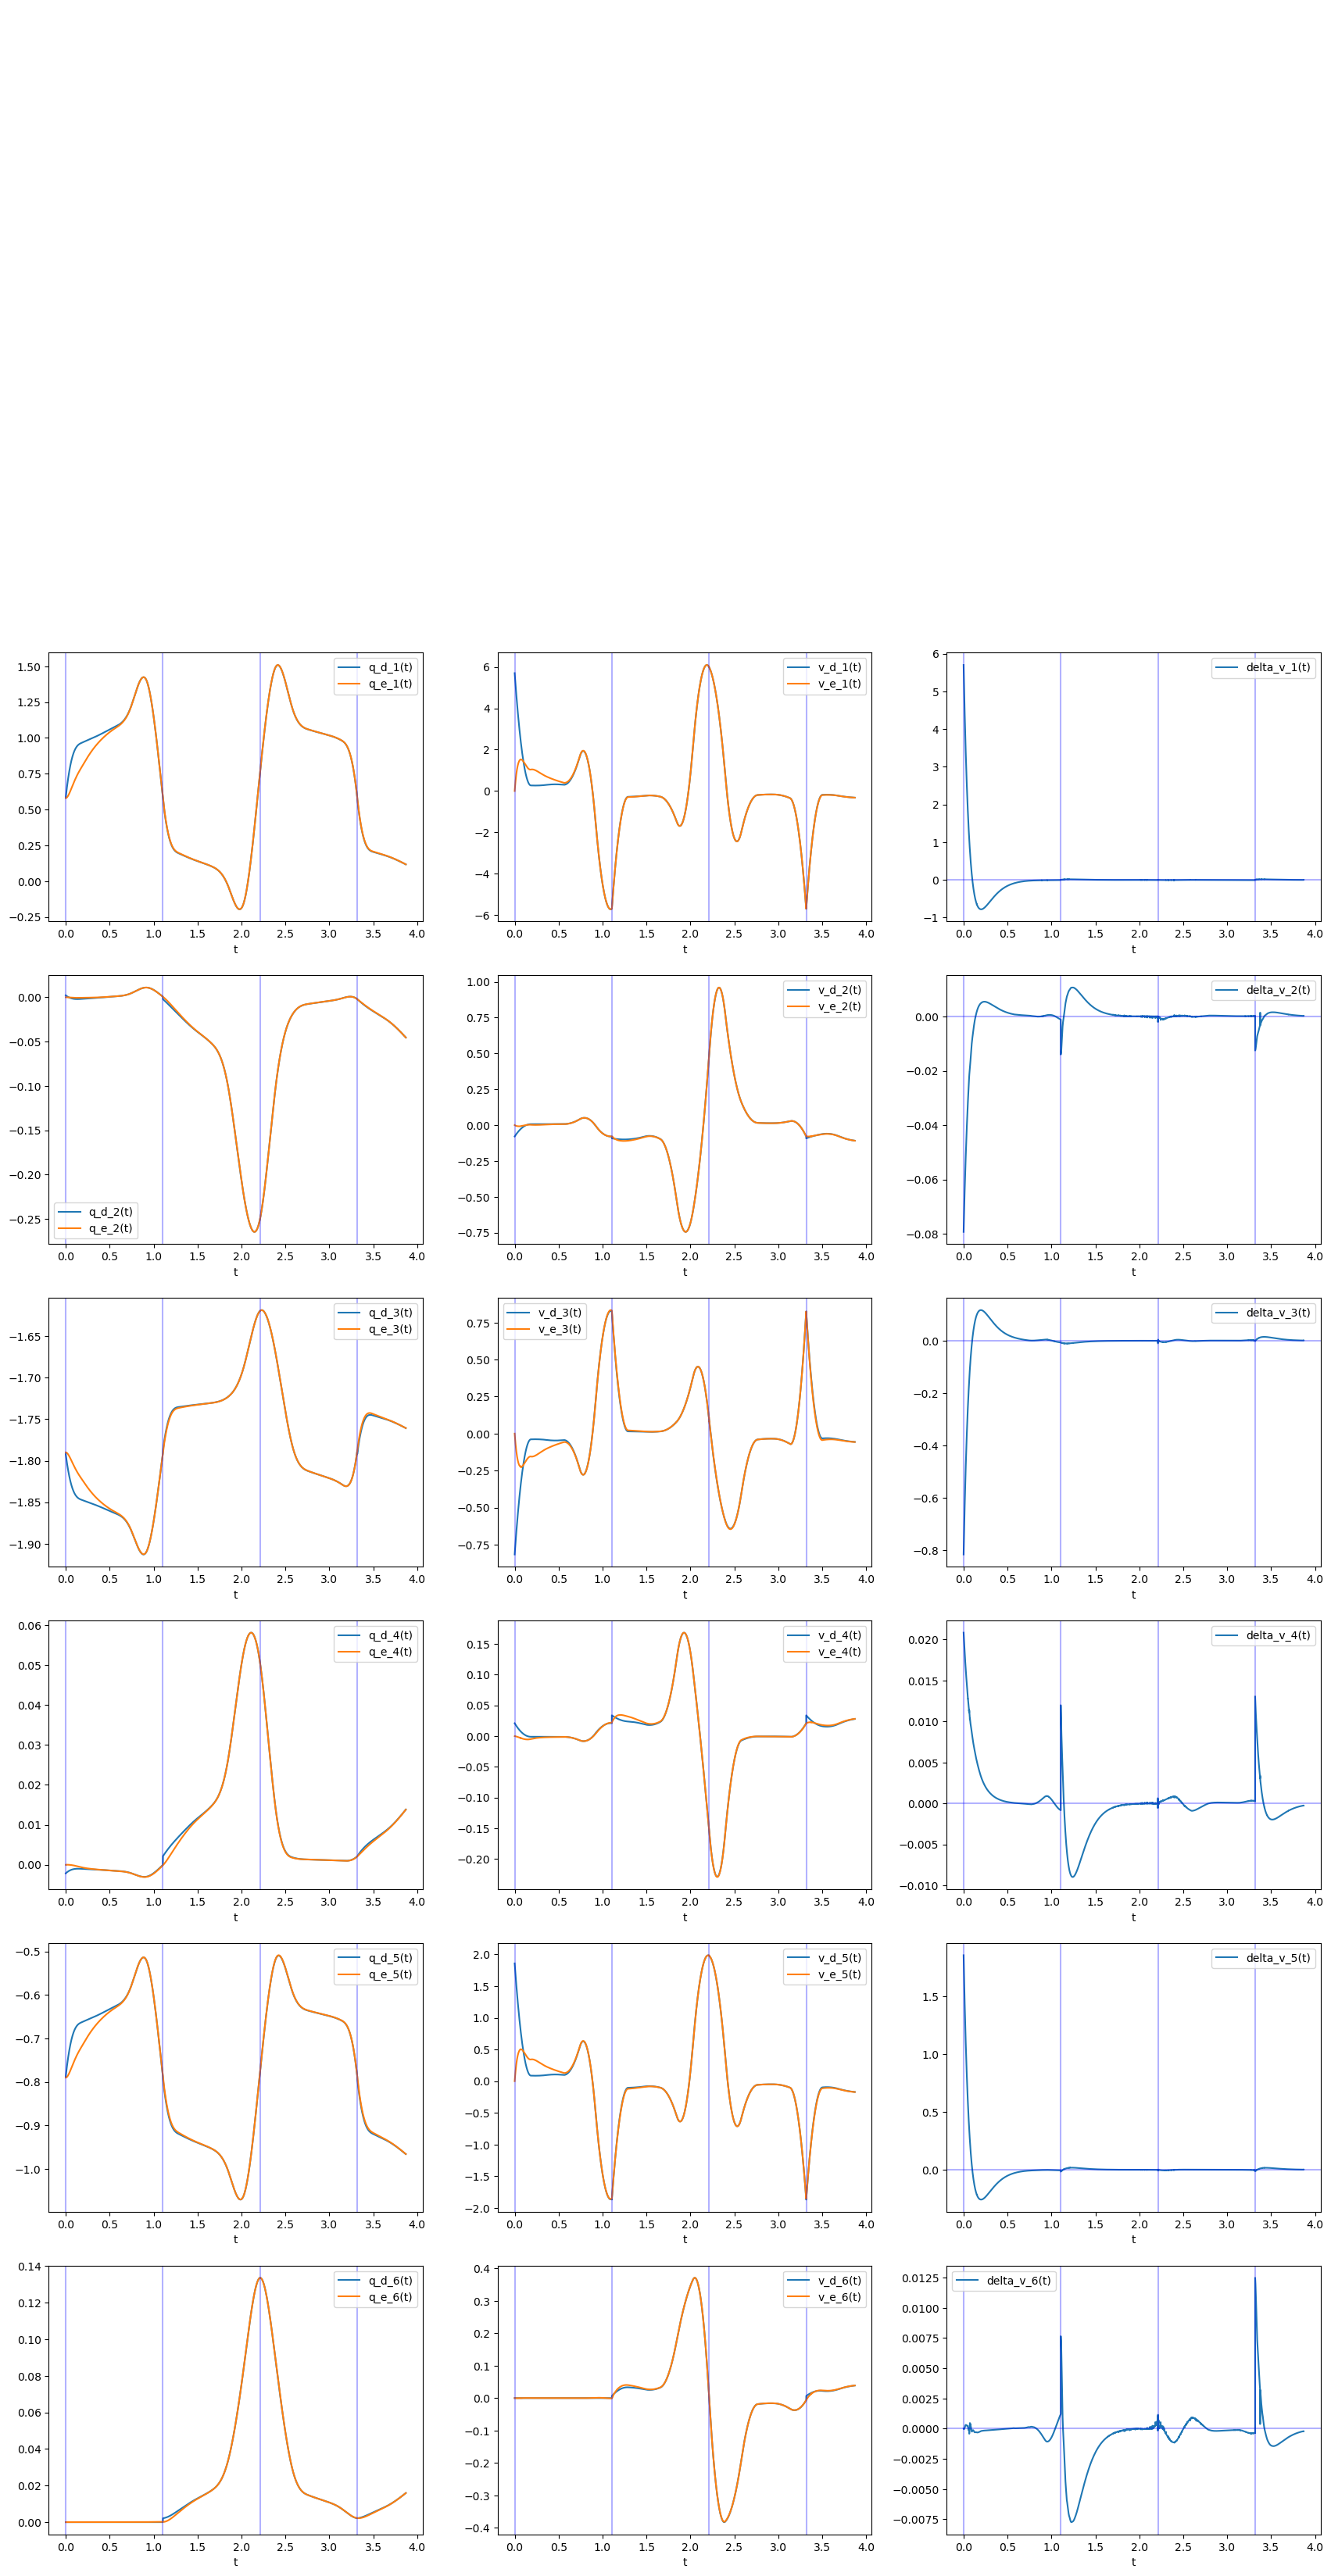

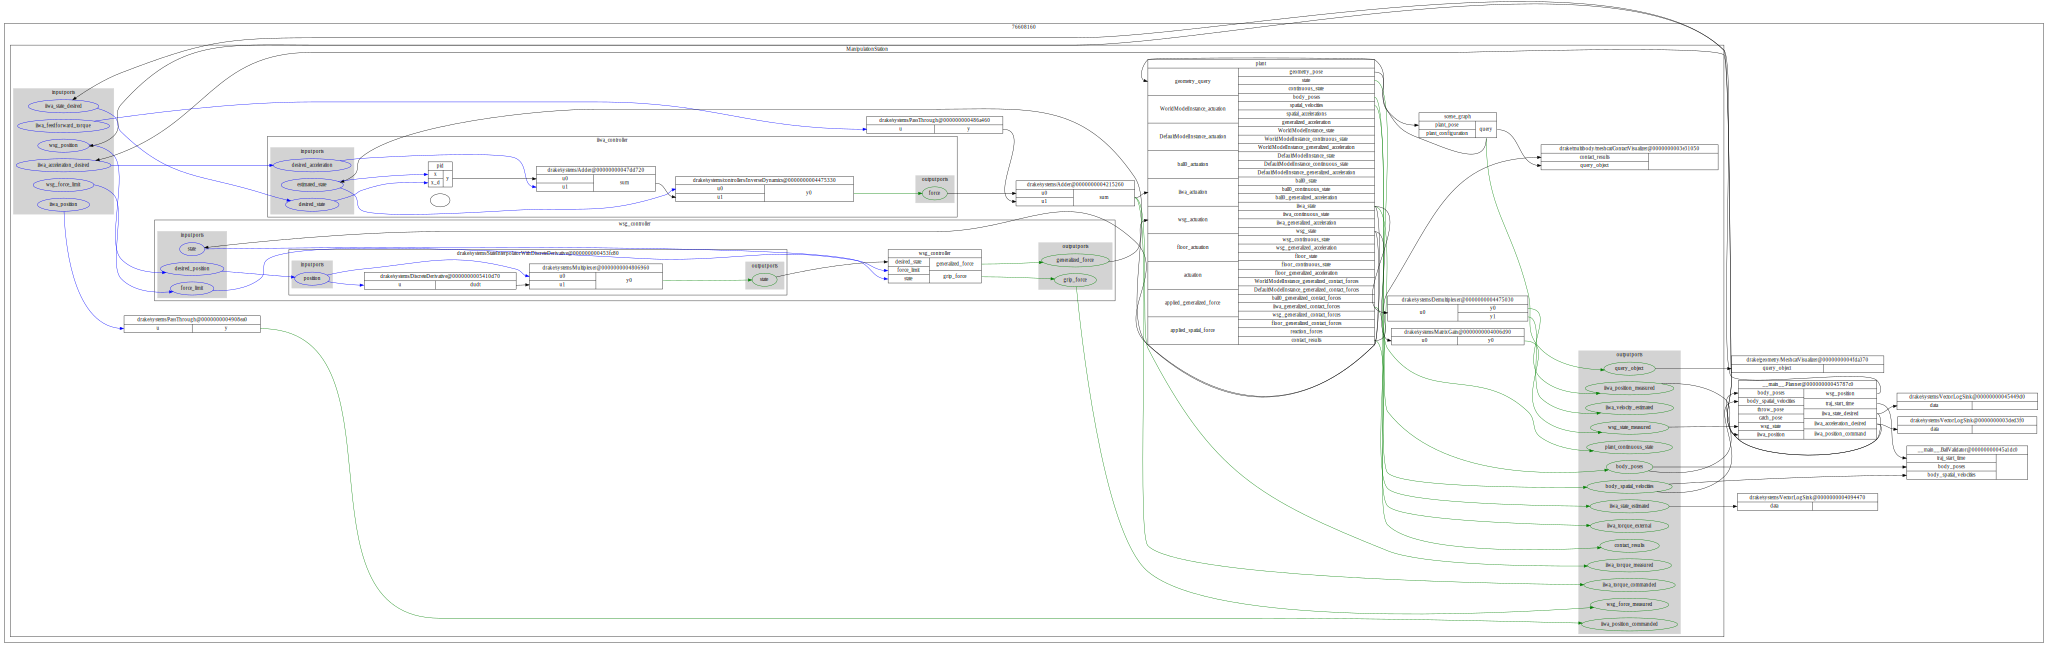

In [ ]:
def clutter_clearing_demo():
    meshcat.Delete()
    builder = DiagramBuilder()

    model_directives = """
directives:
"""

    for i in range(1 if running_as_notebook else 2):
        model_directives += f"""
- add_model:
    name: ball{i}
    file: package://one_arm_juggling/models/ball.sdf
"""
    # use_direct determines whether to feed the desired q, v, a into InverseDynamicsController
    # or to use the default position based iiwa controller
    if use_direct:
        station = builder.AddSystem(
                            MakeDirectManipulationStation(
                                model_directives,
                                filename="./models/one_arm_juggling_no_cams.dmd.yaml",
                                package_xmls=["./package.xml"],
                                time_step=time_step,
                                meshcat=meshcat))
    else:
        station = builder.AddSystem(
                            MyMakeManipulationStation(
                                model_directives,
                                filename="./models/one_arm_juggling.dmd.yaml",
                                package_xmls=["./package.xml"],
                                time_step=time_step))

    plant = station.GetSubsystemByName("plant")

    #ball_validator
    ball = plant.GetBodyByName("ball")

    ball_validator = builder.AddSystem(
                                BallValidator(
                                    ball.name(), 
                                    ball.index()))

    # planner
    planner = builder.AddSystem(Planner(plant, ball.index()))
    builder.Connect(station.GetOutputPort("body_poses"),
                    planner.GetInputPort("body_poses"))
    builder.Connect(station.GetOutputPort("body_spatial_velocities"),
                    planner.GetInputPort("body_spatial_velocities"))
    builder.Connect(station.GetOutputPort("wsg_state_measured"),
                    planner.GetInputPort("wsg_state"))
    builder.Connect(station.GetOutputPort("iiwa_position_measured"),
                    planner.GetInputPort("iiwa_position"))

    builder.Connect(planner.GetOutputPort("wsg_position"),
                    station.GetInputPort("wsg_position"))

    if use_direct:
        builder.Connect(planner.GetOutputPort("iiwa_state_desired"),
                        station.GetInputPort("iiwa_state_desired"))

        builder.Connect(planner.GetOutputPort("iiwa_acceleration_desired"),
                        station.GetInputPort("iiwa_acceleration_desired"))
    else:       
        builder.Connect(planner.GetOutputPort("iiwa_position_command"),
                        station.GetInputPort("iiwa_position"))
    
    builder.Connect(station.GetOutputPort("body_poses"),
                    ball_validator.GetInputPort("body_poses"))
    builder.Connect(planner.GetOutputPort("traj_start_time"),
                    ball_validator.GetInputPort("traj_start_time"))
    builder.Connect(station.GetOutputPort("body_spatial_velocities"),
                    ball_validator.GetInputPort("body_spatial_velocities"))

    meshcat_param = MeshcatVisualizerParams()
    """ kProximity for collision geometry and kIllustration for visual geometry """
    meshcat_param.role = Role.kIllustration
    visualizer = MeshcatVisualizer.AddToBuilder(
        builder, station.GetOutputPort("query_object"), meshcat, meshcat_param)

    if should_print_contact_results:
        print_contact_results = builder.AddSystem(PrintContactResults())
        builder.Connect(station.GetOutputPort("contact_results"),
                        print_contact_results.get_input_port())

    if display_plot:
        logger_state_desired = LogVectorOutput(
            planner.GetOutputPort("iiwa_state_desired"), builder
            )
        logger_state_estimated = LogVectorOutput(
            station.GetOutputPort("iiwa_state_estimated"), builder
            )
        logger_acceleration_desired = LogVectorOutput(
            planner.GetOutputPort("iiwa_acceleration_desired"), builder
            )
        # logger_acceleration_estimated = LogVectorOutput(
        #     station.GetOutputPort("iiwa_acceleration_estimated"), builder
        #     )

    diagram = builder.Build()
    simulator = Simulator(diagram)
    context = simulator.get_context()
    X_WThrowB_W, X_WCatchB_W = get_ball_poses_from_gripper_poses(X_WThrow, X_WCatch, p_GB_G)
    add_target_spheres(X_WThrowB_W, X_WCatchB_W, meshcat)
    
    plant_context = plant.GetMyMutableContextFromRoot(context)
    for body_index in plant.GetFloatingBaseBodies():
        tf = RigidTransform(X_WCatchB_W.rotation(), X_WCatchB_W.translation()) 
        # for starting from drop add to translation np.array([0,0,6])
        # np.array([0,0,-0.015])
        plant.SetFreeBodyPose(plant_context,
                              plant.get_body(body_index),
                              tf)

    if add_text_to_pdf:
        buffer = StringIO()
        sys.stdout = buffer
    
    print(f"--- Experiment Parameters ---")
    print(f"Controller: Feed in desired q,v,a : {use_direct}")
    print(f"simulation duration: {sim_duration}")
    print(f"manipulation station time step: {time_step}")
    print(f"kin traj opt num control points: {num_control_points}")
    print(f"max height: {max_height}")
    print(f"-----------------------------")
    print(f"planned ball THROW time: {t_duration}")
    print(f"planned ball THROW position: {X_WThrowB_W.translation()}")
    print(f"planned ball THROW velocity: {V_ThrowB}")
    # print(f"planned ball THROW velocity (joints): {v_Throw.flatten()}")
    print(f"planned ball CATCH time: {2 * t_duration}")
    print(f"planned ball CATCH position: {X_WCatchB_W.translation()}")
    print(f"planned ball CATCH velocity: {V_CatchB}")
    # print(f"planned ball CATCH velocity (joints): {v_Catch.flatten()}")

    q0 = plant.GetPositions(plant_context)
    non_iiwa_q0 = q0[7:]
    gap = closed[0]
    non_iiwa_q0[0]=-gap/2
    non_iiwa_q0[1]=gap/2
    plant.SetPositions(plant_context, np.concatenate((q_Catch, non_iiwa_q0)))
    simulator.AdvanceTo(0)
    meshcat.Flush()  # Wait for the large object meshes to get to meshcat.
    # Recorder
    RecordInterval(0, sim_duration, simulator, context, plant, visualizer)

    def plot_vertical_lines():
        num_lines = round(sim_duration/t_duration)
        for i in range(num_lines):
            plt.axvline(x = i*t_duration, color = 'b', alpha=0.3)
    if display_plot:
        log_state_desired = logger_state_desired.FindLog(context)
        log_state_estimated = logger_state_estimated.FindLog(context)

        f = plt.figure(figsize=(21,42))

        # print('--- Catch at t=0 ---')
        # catch_time_indices = np.where(log_state_desired.sample_times() == 0)
        # for i in range(7):
        #     print(f"v_e_{i}: {log_state_estimated.data()[7+i,:].transpose()[catch_time_indices[0]][:1]}   v_d_{i}: {log_state_desired.data()[7+i,:].transpose()[catch_time_indices[0]][:1]}   v_Catch: {v_Catch[i][:1]}")

        # print(f'--- Throw at t={t_duration}---')
        throw_time_indices = np.where(log_state_desired.sample_times() == t_duration)
        for i in range(7):
            # print(f"v_e_{i}: {log_state_estimated.data()[7+i,:].transpose()[throw_time_indices[0]]}   v_d_{i}: {log_state_desired.data()[7+i,:].transpose()[throw_time_indices[0]]}   v_Throw: {v_Throw[i]}")
            plt.subplot(8, 3, 4 + i*3)
            plt.plot(log_state_desired.sample_times(),
                    log_state_desired.data()[i,:].transpose(),
                    log_state_estimated.sample_times(),
                    log_state_estimated.data()[i,:].transpose())
            # plt.axvline(x = t_duration, color = 'b', alpha=0.3)
            plot_vertical_lines()
            plt.legend([f'q_d_{i}(t)', f'q_e_{i}(t)'])
            plt.xlabel('t');


            plt.subplot(8, 3, 5 + i*3)
            plt.plot(log_state_desired.sample_times(),
                    log_state_desired.data()[7+i,:].transpose(),
                    log_state_estimated.sample_times(),
                    log_state_estimated.data()[7+i,:].transpose())
            plot_vertical_lines()
            plt.legend([f'v_d_{i}(t)', f'v_e_{i}(t)'])
            plt.xlabel('t');

            plt.subplot(8, 3, 6 + i*3)
            plt.plot(log_state_desired.sample_times(),
                    log_state_desired.data()[7+i,:].transpose() - log_state_estimated.data()[7+i,:].transpose())
            plot_vertical_lines()
            plt.axhline(y = 0, color = 'b', alpha=0.3)
            plt.legend([f'delta_v_{i}(t)'])
            plt.xlabel('t');

        # print(f'--- Catch at t={2*t_duration} ---')
        # catch_time_indices = np.where(log_state_desired.sample_times() == 2*t_duration)
        # for i in range(7):
        #     print(f"v_e_{i}: {log_state_estimated.data()[7+i,:].transpose()[catch_time_indices[0]][:1]}   v_d_{i}: {log_state_desired.data()[7+i,:].transpose()[catch_time_indices[0]][:1]}   v_Catch: {v_Catch[i][:1]}")
        

        plt.subplot(4, 1, 1)
        plt.axis('off')
        if add_text_to_pdf:
            print_output = buffer.getvalue()
            sys.stdout = sys.__stdout__
            plt.text(0, 0, print_output, fontsize='x-large')
        plt.savefig('plots/test.pdf')
        plt.show()


    display(SVG(pydot.graph_from_dot_data(diagram.GetGraphvizString())[0].create_svg()))
    pydot.graph_from_dot_data(diagram.GetGraphvizString())[0].write_svg("diagram.svg")

clutter_clearing_demo()

In [ ]:
%tb

No traceback available to show.


<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=68a898be-bd4e-4046-916a-6293aadf6c5d' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>